In [2]:
!pip install librosa
!pip install torch torchvision torchaudio
!apt install -y ffmpeg
!pip install shap

import shap
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from zipfile import ZipFile

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import train_test_split
import torchaudio
from google.colab import files

!pip install lime

import numpy as np
import torch
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [3]:
uploaded = files.upload()

with ZipFile("dataset_3.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset_3")

data_path = "./dataset_3/dataset_3"

Saving dataset_3.zip to dataset_3 (3).zip


In [4]:
print(os.listdir("./dataset_3/dataset_3"))

['R_027.mp3', 'L_015.mp3', 'L_150.mp3', 'R_004.mp3', 'L_048.mp3', 'R_056.mp3', 'L_124.mp3', 'L_171.mp3', 'L_047.mp3', 'L_119.mp3', 'R_026.mp3', 'L_001.mp3', 'L_179.mp3', 'R_009.mp3', 'L_086.mp3', 'R_147.mp3', 'L_051.mp3', 'R_020.mp3', 'R_124.mp3', 'R_158.mp3', 'R_084.mp3', 'R_011.mp3', 'L_006.mp3', 'L_181.mp3', 'R_014.mp3', 'L_166.mp3', 'L_064.mp3', 'R_037.mp3', 'L_094.mp3', 'L_149.mp3', 'R_083.mp3', 'R_076.mp3', 'L_157.mp3', 'R_109.mp3', 'R_070.mp3', 'R_168.mp3', 'R_140.mp3', 'L_090.mp3', 'L_145.mp3', 'L_056.mp3', 'L_108.mp3', 'L_062.mp3', 'R_050.mp3', 'L_026.mp3', 'R_118.mp3', 'L_152.mp3', 'R_110.mp3', 'L_040.mp3', 'R_144.mp3', 'L_131.mp3', 'L_127.mp3', 'L_012.mp3', 'L_035.mp3', 'L_066.mp3', 'R_057.mp3', 'R_103.mp3', 'L_178.mp3', 'R_180.mp3', 'L_154.mp3', 'R_141.mp3', 'R_006.mp3', 'L_103.mp3', 'L_096.mp3', 'L_009.mp3', 'L_175.mp3', 'L_032.mp3', 'R_113.mp3', 'R_098.mp3', 'R_133.mp3', 'L_003.mp3', 'R_080.mp3', 'R_044.mp3', 'R_162.mp3', 'R_088.mp3', 'L_114.mp3', 'L_046.mp3', 'L_134.mp3'

In [5]:
for f in os.listdir(data_path):
    if f.endswith(".mp3"):
        w, sr = torchaudio.load(os.path.join(data_path, f))
        print(f"{f}: {w.shape[1]} samples, {w.shape[0]} channels, sr = {sr}")

R_027.mp3: 43419 samples, 2 channels, sr = 44100
L_015.mp3: 39451 samples, 2 channels, sr = 44100
L_150.mp3: 42907 samples, 2 channels, sr = 44100
R_004.mp3: 41115 samples, 2 channels, sr = 44100
L_048.mp3: 41755 samples, 2 channels, sr = 44100
R_056.mp3: 43419 samples, 2 channels, sr = 44100
L_124.mp3: 42907 samples, 2 channels, sr = 44100
L_171.mp3: 38299 samples, 2 channels, sr = 44100
L_047.mp3: 42907 samples, 2 channels, sr = 44100
L_119.mp3: 42907 samples, 2 channels, sr = 44100
R_026.mp3: 43419 samples, 2 channels, sr = 44100
L_001.mp3: 40603 samples, 2 channels, sr = 44100
L_179.mp3: 41755 samples, 2 channels, sr = 44100
R_009.mp3: 43419 samples, 2 channels, sr = 44100
L_086.mp3: 41755 samples, 2 channels, sr = 44100
R_147.mp3: 42267 samples, 2 channels, sr = 44100
L_051.mp3: 39451 samples, 2 channels, sr = 44100
R_020.mp3: 43419 samples, 2 channels, sr = 44100
R_124.mp3: 42267 samples, 2 channels, sr = 44100
R_158.mp3: 42267 samples, 2 channels, sr = 44100
R_084.mp3: 44571 sam

In [6]:
SAMPLE_RATE = 22050
N_MELS = 64 #штука по высоте
MAX_LEN = 100  #с прышком hop_length = 10 по дефолту, по горизонтали


def extract_mel_spec(filepath, SAMPLE_RATE, N_MELS, MAX_LEN):
    y, sr = librosa.load(filepath, sr=SAMPLE_RATE, mono = False)

    mel_specs = []

    for channel in range(2):

      mel_spec = librosa.feature.melspectrogram(y=y[channel], sr=sr, n_mels=N_MELS)
      mel_db = librosa.power_to_db(mel_spec, ref=np.max)

      if mel_db.shape[1] < MAX_LEN:
          mel_db = np.pad(mel_db, ((0, 0), (0, MAX_LEN - mel_db.shape[1])), mode='constant')
      else:
          mel_db = mel_db[:, :MAX_LEN]

      mel_specs.append(mel_db)

    return mel_specs[0], mel_specs[1]


data = []
for filename in os.listdir(data_path):
    if not filename.endswith(".mp3"):
        continue

    if filename.startswith("L_"):
        label = 0
    elif filename.startswith("R_"):
        label = 1
    else:
        continue

    filepath = os.path.join(data_path, filename)

    mel_left, mel_right = extract_mel_spec(filepath, SAMPLE_RATE, N_MELS, MAX_LEN)

    data.append((mel_left, mel_right, label))


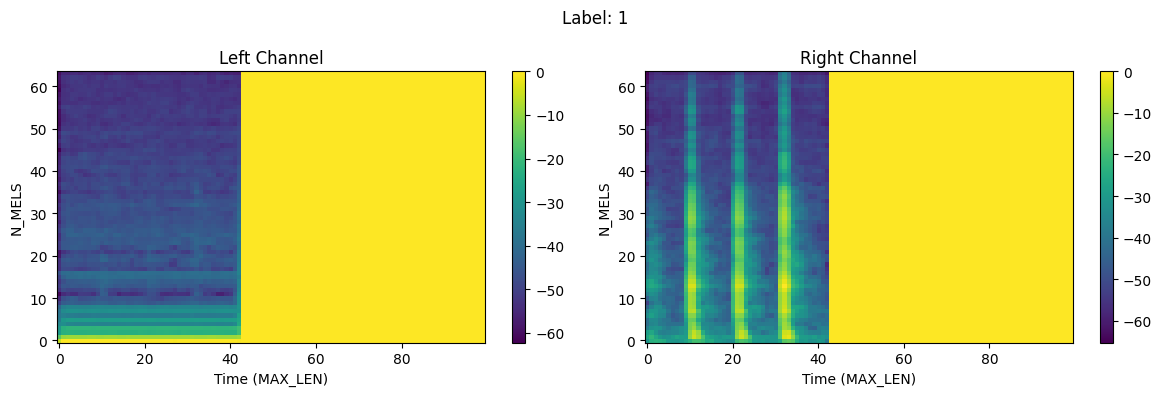

In [7]:
mel_left, mel_right, label = data[0]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(mel_left, aspect='auto', origin='lower', cmap='viridis')
plt.title("Left Channel")
plt.xlabel("Time (MAX_LEN)")
plt.ylabel("N_MELS")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(mel_right, aspect='auto', origin='lower', cmap='viridis')
plt.title("Right Channel")
plt.xlabel("Time (MAX_LEN)")
plt.ylabel("N_MELS")
plt.colorbar()

plt.suptitle(f"Label: {label}")
plt.tight_layout()
plt.show()

In [8]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

print(f"Всего примеров: {len(data)}")
print(f"Тренировочных: {len(train_data)}")
print(f"Тестовых: {len(test_data)}")

Всего примеров: 366
Тренировочных: 292
Тестовых: 74


In [9]:
class MelDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        mel_left, mel_right, label = self.data[idx]
        mel = np.stack([mel_left, mel_right], axis=0).astype(np.float32)
        return torch.tensor(mel), torch.tensor(label, dtype=torch.long)

In [10]:
class MelCNN(nn.Module):
    def __init__(self):
        super(MelCNN, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 25, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.avg_pool2d(F.relu(self.conv1(x)), 2)
        x = F.avg_pool2d(F.relu(self.conv2(x)), 2)
        x = x.contiguous().view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
train_dataset = MelDataset(train_data)
test_dataset = MelDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10)

model = MelCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001)

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(10):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_loss = total_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total_test += y_batch.size(0)
            correct_test += (predicted == y_batch).sum().item()
    test_acc = 100 * correct_test / total_test
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

Epoch 1, Loss: 0.9236, Train Acc: 49.32%, Test Acc: 51.35%
Epoch 2, Loss: 0.6364, Train Acc: 56.16%, Test Acc: 82.43%
Epoch 3, Loss: 0.4986, Train Acc: 97.26%, Test Acc: 95.95%
Epoch 4, Loss: 0.4200, Train Acc: 100.00%, Test Acc: 95.95%
Epoch 5, Loss: 0.3777, Train Acc: 100.00%, Test Acc: 95.95%
Epoch 6, Loss: 0.3426, Train Acc: 100.00%, Test Acc: 95.95%
Epoch 7, Loss: 0.3201, Train Acc: 100.00%, Test Acc: 95.95%
Epoch 8, Loss: 0.2902, Train Acc: 100.00%, Test Acc: 95.95%
Epoch 9, Loss: 0.2659, Train Acc: 100.00%, Test Acc: 95.95%
Epoch 10, Loss: 0.2483, Train Acc: 100.00%, Test Acc: 95.95%


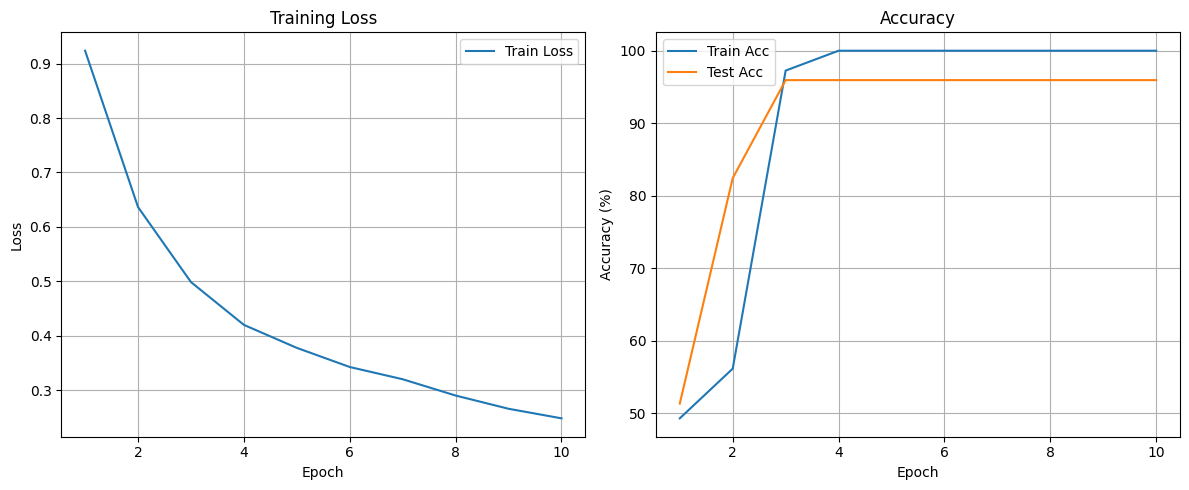

In [12]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, test_accuracies, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Background shape: torch.Size([4, 2, 64, 100])
Test examples shape: torch.Size([4, 2, 64, 100])
SHAP shape: (64, 100, 2)


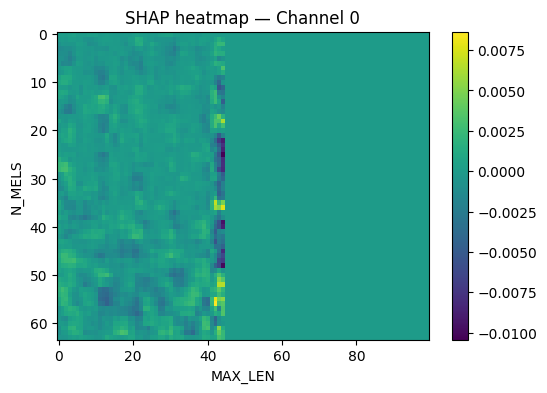

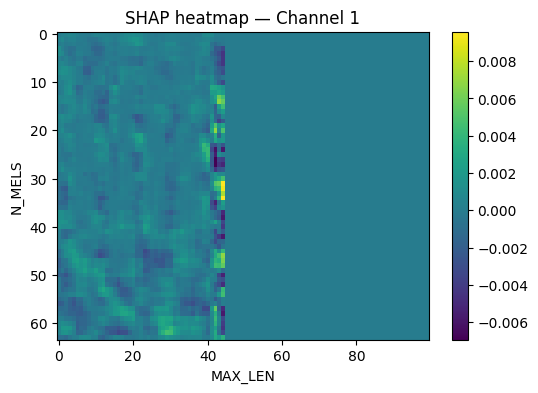

In [13]:
X_batch, y_batch = next(iter(test_loader))
background = X_batch[:4]
test_examples = X_batch[4:8]

print("Background shape:", background.shape)
print("Test examples shape:", test_examples.shape)

explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(test_examples)
#shap.summary_plot(shap_values, test_examples)
i = 0

print("SHAP shape:", shap_values[0][i].shape)

shap_tensor = torch.from_numpy(shap_values[0][i]).permute(2, 0, 1)



for channel in range(shap_tensor.shape[0]):
    shap_map = shap_tensor[channel]  # (64, 100)
    plt.figure(figsize=(6, 4))
    plt.imshow(shap_map, cmap='viridis', aspect='auto')
    plt.title(f"SHAP heatmap — Channel {channel}")
    plt.colorbar()
    plt.xlabel("MAX_LEN")
    plt.ylabel("N_MELS")
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

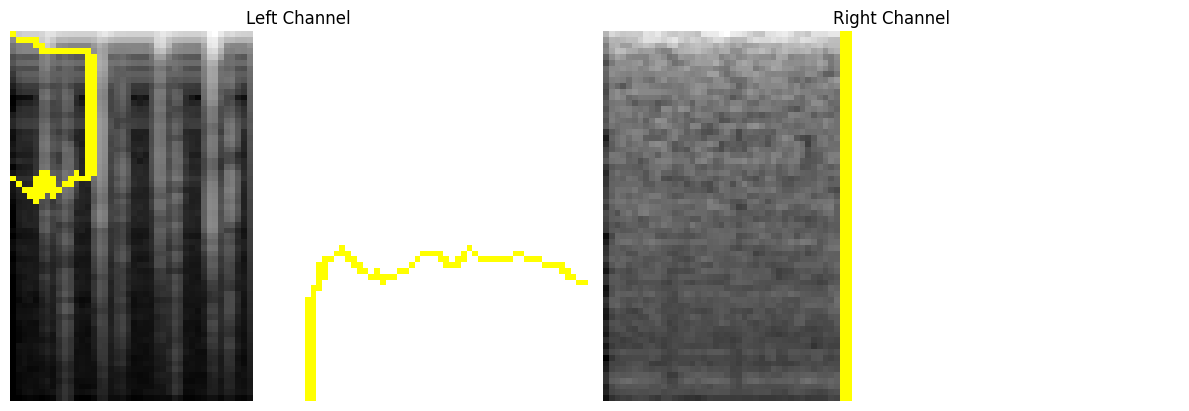

In [14]:
def predict_fn(images_np):
    '''
    ИЗ (H, W, 3) в (2, 64, 200)
    '''
    model.eval()
    with torch.no_grad():
        images_torch = torch.tensor(images_np.transpose(0, 3, 1, 2), dtype=torch.float32)
        images_torch = images_torch[:, :2, :, :]
        outputs = model(images_torch)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        return probs.numpy()

explainer = lime_image.LimeImageExplainer()

mel_example = test_dataset[0][0].numpy()  # (3, 64, 200)
left_mel = mel_example[0]  # (64, 200)
right_mel = mel_example[1]  # (64, 200)

def preprocess(channel_mel):
    mel_rgb = np.stack([channel_mel, channel_mel, channel_mel], axis=-1)  # (64, 200, 3)
    mel_norm = (mel_rgb - mel_rgb.min()) / (mel_rgb.max() - mel_rgb.min())
    return (mel_norm * 255).astype(np.uint8)

left_img = preprocess(left_mel)
right_img = preprocess(right_mel)

exp_left = explainer.explain_instance(left_img, classifier_fn=predict_fn, top_labels=1, num_samples=1000)
img_l, mask_l = exp_left.get_image_and_mask(exp_left.top_labels[0], positive_only=True, hide_rest=False)

exp_right = explainer.explain_instance(right_img, classifier_fn=predict_fn, top_labels=1, num_samples=1000)
img_r, mask_r = exp_right.get_image_and_mask(exp_right.top_labels[0], positive_only=True, hide_rest=False)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(mark_boundaries(img_l, mask_l))
axs[0].set_title("Left Channel")
axs[0].axis('off')

axs[1].imshow(mark_boundaries(img_r, mask_r))
axs[1].set_title("Right Channel")
axs[1].axis('off')

plt.tight_layout()
plt.show()